## Milestone 5: Advanced Model Development

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
df = pd.read_csv("dynamic_pricing.csv")

df.head()


,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422



Replacing missing numeric values with the column median.  

 Adding new derived features:
  - `Demand_Supply_Ratio` → Number_of_Riders / (Number_of_Drivers + 1)
  - `Ride_Experience` → combines Number_of_Past_Rides × Average_Ratings

Applying log transformation on target (`Historical_Cost_of_Ride`) to reduce skewness and stabilize variance.

In [3]:
# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

df['Demand_Supply_Ratio'] = df['Number_of_Riders'] / (df['Number_of_Drivers'] + 1)
df['Ride_Experience'] = df['Number_of_Past_Rides'] * df['Average_Ratings']

# Log transformation for skewed features
df['Historical_Cost_of_Ride'] = np.log1p(df['Historical_Cost_of_Ride'])



Mapping loyalty levels with ordinal values.  
Applying one-hot encoding on categorical columns like location, booking time, and vehicle type to prepare for model training.

In [4]:
loyalty_order = {'Regular': 0, 'Silver': 1, 'Gold': 2}
df['Customer_Loyalty_Status'] = df['Customer_Loyalty_Status'].map(loyalty_order)


df = pd.get_dummies(df, columns=['Location_Category', 'Time_of_Booking', 'Vehicle_Type'], drop_first=True)


Splitting the dataset into training and testing sets for model evaluation and avoiding overfitting.

In [5]:

X = df.drop(['Historical_Cost_of_Ride'], axis=1)
y = df['Historical_Cost_of_Ride']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training XGBoost model with tuned parameters like learning rate, max depth, and subsample ratio to capture complex non-linear pricing relationships.  
Evaluating model performance using MAE and R² score to check prediction accuracy and model fit quality.

In [6]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42
)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.3f}")


Mean Absolute Error: 0.15
R² Score: 0.924


Training LightGBM model for price prediction by using regularization, subsampling and feature sampling to enhance performance and reduce overfitting.

In [7]:
lgbm_model = LGBMRegressor(
    n_estimators=300,       # number of trees
    learning_rate=0.05,     # smaller step = smoother learning
    max_depth=-1,           # allows trees to grow as needed
    subsample=0.8,          # randomly samples data to prevent overfitting
    colsample_bytree=0.8,   # randomly samples features per tree
    reg_alpha=0.2,          # L1 regularization
    reg_lambda=1.0,         # L2 regularization
    random_state=42
)

lgbm_model.fit(X_train, y_train)


d:\VS Codes\codes\python.py\ai_price_optima\env\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\VS Codes\codes\python.py\ai_price_optima\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "d:\VS Codes\codes\python.py\ai_price_optima\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\subprocess.py

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1067
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 14
[LightGBM] [Info] Start training from score 5.750716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Evaluating LightGBM predictions using MAE and R² metrics.  

In [8]:
y_pred_lgbm = lgbm_model.predict(X_test)

mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"LightGBM Model Results:")
print(f"Mean Absolute Error (MAE): {mae_lgbm:.2f}")
print(f"R² Score: {r2_lgbm:.3f}")


LightGBM Model Results:
Mean Absolute Error (MAE): 0.14
R² Score: 0.927


Visualizing top 10 most important features affecting ride cost.

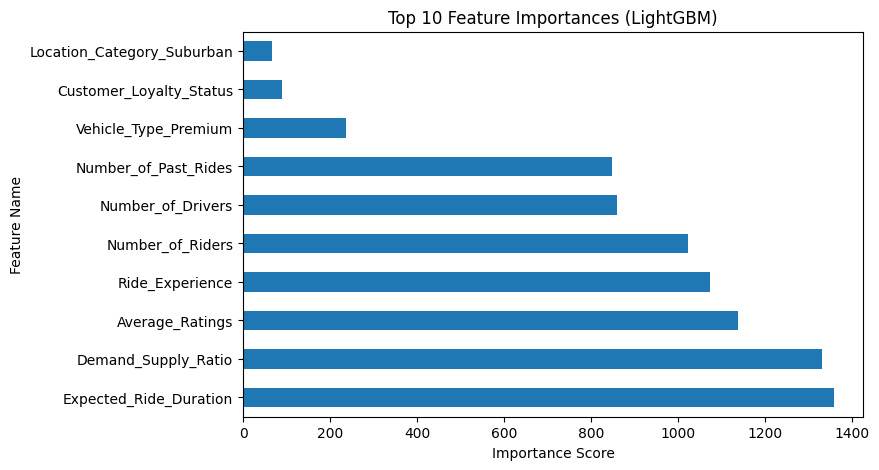

In [9]:
importances = pd.Series(lgbm_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh', figsize=(8,5))
plt.title("Top 10 Feature Importances (LightGBM)")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()


Comparing predicted prices with historical prices on test data.  
Calculating simulated revenue lift percentage to measure dynamic pricing performance against baseline static pricing.

In [10]:
# Creating a new DataFrame for the test set results
results_df = pd.DataFrame({
    'Actual_Price_Log': y_test,
    'Predicted_Price_Log': y_pred
})

# Converting log values back to real prices using np.expm1
results_df['Actual_Price'] = np.expm1(results_df['Actual_Price_Log'])
results_df['Predicted_Price'] = np.expm1(results_df['Predicted_Price_Log'])


# Calculating total revenues
baseline_revenue = results_df['Actual_Price'].sum()
dynamic_revenue = results_df['Predicted_Price'].sum()

# KPI: Simulated Revenue Lift (%)
kpi_revenue_lift = ((dynamic_revenue - baseline_revenue) / baseline_revenue) * 100

print(f"Simulated Revenue Lift: {kpi_revenue_lift:.2f}%")

Simulated Revenue Lift: 0.29%


In [11]:
# Summary Table
summary = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM'],
    'MAE': [mae, mae_lgbm],
    'R2 Score': [r2, r2_lgbm]
})

print("✅ Milestone 5 Summary:")
print(summary)

✅ Milestone 5 Summary:
      Model       MAE  R2 Score
0   XGBoost  0.147146  0.923827
1  LightGBM  0.144091  0.926603


### Backtesting
Applying the trained model on past unseen data and comparing predicted results with actual values

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores, r2_scores = [], []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train) #xgb model
    y_pred = model.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average R² Score: {np.mean(r2_scores):.3f}")


Average MAE: 0.15
Average R² Score: 0.922
